In [1]:
import pandas as pd
import matplotlib.pyplot as plt

p = plt.rcParams
p["font.sans-serif"] = ["Atkinson Hyperlegible"]
p["font.weight"] = "light"

In [2]:
df = pd.read_csv("../data/dsd-melody-place-counts-census.csv")
df.head()

,melodieid,count,place
0,6451,44,Alkmaar
1,6124,40,Alkmaar
2,8349,29,Alkmaar
3,9073,24,Alkmaar
4,7393,18,Alkmaar


In [3]:
from copia.data import to_copia_dataset

datasets = {}
for placename in df["place"].unique():
    ds = to_copia_dataset(df[df["place"] == placename], input_type="counts",
                          index_column="melodieid", count_column="count")
    datasets[placename] = ds

/Users/folgert/projects/coverage-based-standardization/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from copia.rarefaction_extrapolation import species_accumulation

curves = {}
for place, ds in datasets.items():
    curve = species_accumulation(ds, compute_coverage=True)
    curves[place] = curve

100%|██████████| 100/100 [00:02<00:00, 45.29it/s]


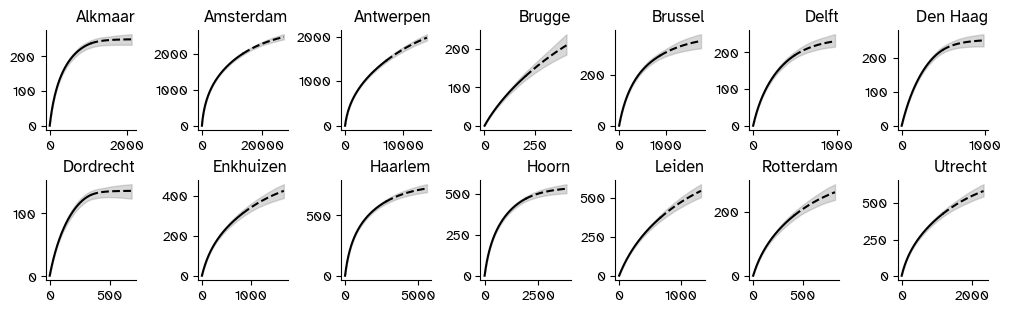

In [5]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(10, 3), constrained_layout=True)
axes = axes.flatten()

for ax in axes:
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

ls = 'solid', 'dashed'

for i, place in enumerate(curves.keys()):
    acc_df = curves[place]
    estimation = acc_df['est'].values
    sample_size = acc_df.index
    interpolated = acc_df['interpolated'].values
    lci = acc_df['lci'].values
    uci = acc_df['uci'].values

    axes[i].plot(sample_size[interpolated], estimation[interpolated], color="black", ls="-")
    axes[i].plot(sample_size[~interpolated], estimation[~interpolated], color="black", ls="--")     
    axes[i].fill_between(sample_size, lci, uci, alpha=0.3, color="grey")
    axes[i].set_title(place, loc="right")

# axes[-1].axis('off')
plt.savefig("../images/rarefaction-extrapolation-sample-size.png", dpi=300)

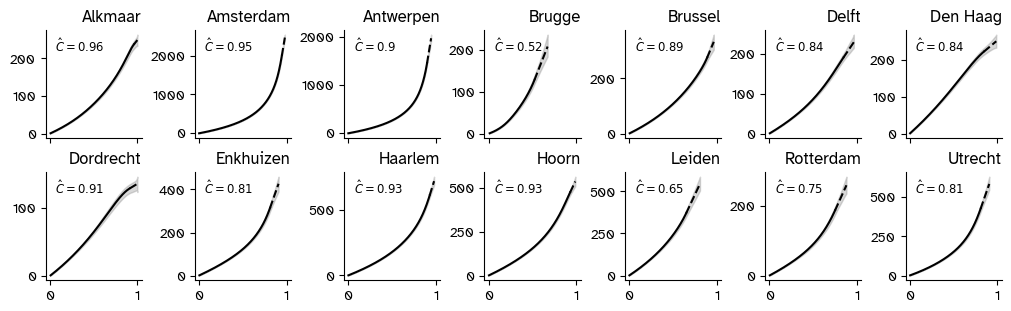

In [6]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(10, 3), sharex=True, constrained_layout=True)
axes = axes.flatten()

for ax in axes:
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

ls = 'solid', 'dashed'

for i, place in enumerate(curves.keys()):
    acc_df = curves[place]
    estimation = acc_df['est'].values
    interpolated = acc_df['interpolated'].values
    coverage = acc_df['coverage'].values
    lci = acc_df['lci'].values
    uci = acc_df['uci'].values    

    axes[i].plot(coverage[interpolated], estimation[interpolated], color="black", ls="-")
    axes[i].plot(coverage[~interpolated], estimation[~interpolated], color="black", ls="--")
    axes[i].fill_between(coverage, lci, uci, alpha=0.3, color="grey")
    axes[i].set_title(place, loc="right")
    axes[i].annotate(fr"$\hat{{C}} = {round(coverage[interpolated].max(), 2)}$", xy=(0.1, 0.8), 
                     xycoords="axes fraction", size="small")

# axes[-1].axis('off')
plt.savefig("../images/rarefaction-extrapolation-coverage.png", dpi=300)

In [7]:
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

# Plot styling constants
STYLES = {
    'interpolated': dict(color="black", ls="-"),
    'extrapolated': dict(color="black", ls="--"),
    'confidence': dict(alpha=0.3, color="grey"),
    'reference': dict(ls="-", lw=0.5, color="grey", zorder=-10),
    'label': dict(size="small", color="black", ha="left", va="center")
}

def setup_base_plot(ax, xlabel):
    """Set up basic plot styling"""
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Expected Richness $E(S_m)$")
    return ax

def plot_curve(place, x_values, df, ax):
    """Plot a single diversity curve with confidence intervals"""
    estimation = df['est'].values
    interpolated = df['interpolated'].values
    lci, uci = df['lci'].values, df['uci'].values

    ax.plot(x_values[interpolated], estimation[interpolated], **STYLES['interpolated'])
    ax.plot(x_values[~interpolated], estimation[~interpolated], **STYLES['extrapolated'])
    ax.fill_between(x_values, lci, uci, **STYLES['confidence'])
    ax.text(x_values[-1], estimation[-1], f"   {place}", **STYLES['label'])

def plot_sample_size_diversity(curves, places, ax=None):
    """Plot diversity curves against sample size"""
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 4))
    ax = setup_base_plot(ax, "Sample size")

    smallest_n = min(curves[place].index.max() - 1 for place in places)
    for place in places:
        df = curves[place].iloc[:smallest_n]
        plot_curve(place, df.index, df, ax)
    
    return ax

def plot_coverage_diversity(curves, places, ax=None):
    """Plot diversity curves against coverage"""
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 4))
    ax = setup_base_plot(ax, "Coverage")

    for place in places:
        df = curves[place]
        plot_curve(place, df['coverage'].values, df, ax)
    
    return ax

def add_reference_points(curves, place_a, place_b, x_values, get_estimates_func, ax):
    """Add reference points and ratio annotations to the plot"""
    for x_val in x_values:
        est_a, est_b = get_estimates_func(curves, place_a, place_b, x_val)
        ax.vlines(x=x_val, ymin=0, ymax=est_a, **STYLES['reference'])
        ax.vlines(x=x_val, ymin=est_a, ymax=est_b, **{**STYLES['reference'], 'ls': '--'})
        
        ratio = max(est_a, est_b) / min(est_a, est_b)
        x_offset = 8 if isinstance(x_val, (int, np.integer)) else 0.003
        ax.annotate(f"{ratio:.2f}", (x_val + x_offset, 0), 
                   rotation=90, fontsize='small', va="bottom")

def get_sample_size_estimates(curves, place_a, place_b, sample_size):
    """Get diversity estimates for a given sample size"""
    return (curves[place_a].iloc[sample_size]['est'],
            curves[place_b].iloc[sample_size]['est'])

def get_coverage_estimates(curves, place_a, place_b, target_coverage):
    """Get diversity estimates for a given coverage value"""
    def get_nearest_estimate(place):
        df = curves[place].round(3)
        idx = abs(df["coverage"] - target_coverage).idxmin() - 1
        return df.iloc[idx]["est"]
    
    return (get_nearest_estimate(place_a), get_nearest_estimate(place_b))

def plot_diversity_comparison(curves, place_a, place_b, coverage_offset=0.1):
    """Create complete diversity comparison plots"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
    
    # Calculate comparison points
    smallest_n = min(df.index.max() - 1 for df in [curves[place_a], curves[place_b]])
    sample_sizes = [int(smallest_n / 3 * i) for i in range(1, 4)]
    
    smallest_c = min(df.loc[df['interpolated'], 'coverage'].max() 
                    for df in [curves[place_a], curves[place_b]])
    max_c = min(df['coverage'].max() for df in [curves[place_a], curves[place_b]])
    coverage_thresholds = np.linspace(
        max(smallest_c - coverage_offset, 0), 
        min(smallest_c + coverage_offset, max_c), num=3)

    # Create plots
    plot_sample_size_diversity(curves, [place_a, place_b], ax1)
    plot_coverage_diversity(curves, [place_a, place_b], ax2)
    
    # Add reference points
    add_reference_points(curves, place_a, place_b, sample_sizes, 
                        get_sample_size_estimates, ax1)
    add_reference_points(curves, place_a, place_b, coverage_thresholds, 
                        get_coverage_estimates, ax2)

    # Add legend
    custom_lines = [Line2D([0], [0], **STYLES['interpolated']),
                   Line2D([0], [0], **STYLES['extrapolated'])]
    fig.legend(custom_lines, ["rarefaction", "extrapolation"],
              edgecolor="None", ncol=2,
              loc="upper center", bbox_to_anchor=(0.5, 1.1),
              borderaxespad=0)
    
    return ax1, ax2

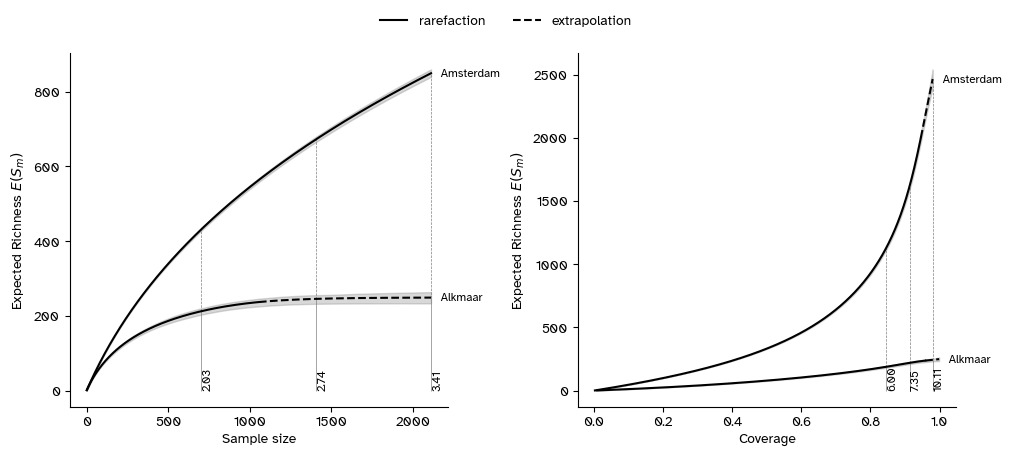

In [8]:
x1, ax2 = plot_diversity_comparison(curves, 'Alkmaar', 'Amsterdam')

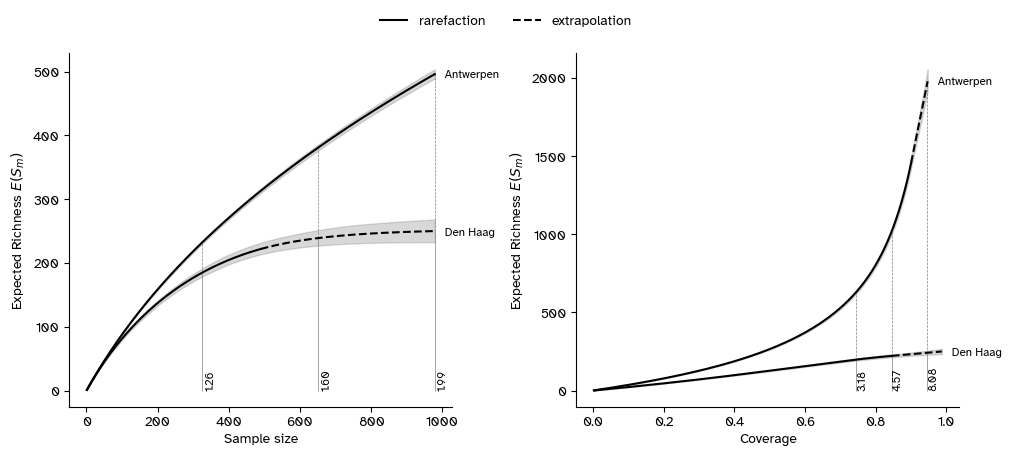

In [9]:
ax0, ax1 = plot_diversity_comparison(curves, "Den Haag", "Antwerpen")

In [10]:
def coverage_interval(ds):
    return 1.96 * ((((ds.f1 + 2 * ds.f2) / ds.n - (ds.f1 / ds.n)**2)/ds.n)**(1/2))

results = []

min_coverage, min_sample_size = None, None

for place in curves.keys():
    df = curves[place]
    df = df[df['interpolated']]
    coverage = df['coverage'].iloc[-1]
    sample_size = df.shape[0] - 1
    if min_coverage is None or coverage < min_coverage:
        min_coverage = coverage
    if min_sample_size is None or sample_size < min_sample_size:
        min_sample_size = sample_size

min_coverage, min_sample_size

for place in curves.keys():
    df = curves[place]
    df = df[df['interpolated']]
    idx = abs(df["coverage"] - min_coverage).idxmin() - 1
    mean_coverage_rarified = df.iloc[idx]["est"]
    mean_size_rarified = df.iloc[min_sample_size]["est"]
    raw_richness = datasets[place].S_obs
    results.append({
        "collection": place, 
        "sample_size": df.shape[0],
        "coverage": df.iloc[-1]["coverage"],
        'raw_richness': raw_richness,
        "C±": coverage_interval(datasets[place]),
        'size_rarified_richness': mean_size_rarified.astype(int),
        'coverage_rarified_richness': mean_coverage_rarified.astype(int)
    })

df = pd.DataFrame(results)
df['raw_rank'] = df['raw_richness'].rank(ascending=False)
df['size_rarified_rank'] = df['size_rarified_richness'].rank(ascending=False)
df['coverage_rarified_rank'] = df['coverage_rarified_richness'].rank(ascending=False)

df

,collection,sample_size,coverage,raw_richness,C±,size_rarified_richness,coverage_rarified_richness,raw_rank,size_rarified_rank,coverage_rarified_rank
0,Alkmaar,1055,0.958333,237,0.026260,115,83,9.0,13.0,13.0
1,Amsterdam,13568,0.945980,2003,0.005454,165,357,1.0,1.0,1.0
2,Antwerpen,7052,0.900326,1459,0.009120,158,285,2.0,2.0,2.0
3,Brugge,200,0.522388,129,0.090508,128,128,13.5,9.5,9.0
4,Brussel,876,0.889396,275,0.031469,128,114,8.0,9.5,10.0
5,Delft,489,0.844898,191,0.053398,119,92,11.0,12.0,12.0
6,Den Haag,489,0.844898,222,0.063525,137,133,10.0,7.0,7.0
7,Dordrecht,339,0.911765,129,0.072771,104,68,13.5,14.0,14.0
8,Enkhuizen,835,0.811005,314,0.036482,134,130,7.0,8.0,8.0
9,Haarlem,2794,0.930590,614,0.014551,148,190,3.0,4.0,4.0


In [11]:
popsize_df = pd.read_csv("../data/population-estimates.csv")
popsize_df = popsize_df[popsize_df["decade"] <= 1700].groupby("location")[["pop_estimate", "error"]].mean().reset_index()
df = df.merge(popsize_df, left_on="collection", right_on="location")
df.head()

,collection,sample_size,coverage,raw_richness,C±,size_rarified_richness,coverage_rarified_richness,raw_rank,size_rarified_rank,coverage_rarified_rank,location,pop_estimate,error
0,Alkmaar,1055,0.958333,237,0.026260,115,83,9.0,13.0,13.0,Alkmaar,12823.996926,0.081479
1,Amsterdam,13568,0.945980,2003,0.005454,165,357,1.0,1.0,1.0,Amsterdam,149677.105070,0.049786
2,Antwerpen,7052,0.900326,1459,0.009120,158,285,2.0,2.0,2.0,Antwerpen,61982.337772,0.076672
3,Brugge,200,0.522388,129,0.090508,128,128,13.5,9.5,9.0,Brugge,30807.493160,0.071676
4,Brussel,876,0.889396,275,0.031469,128,114,8.0,9.5,10.0,Brussel,67286.480064,0.123669


In [12]:
def analyze_rank_changes(df):
    """
    Analyze how rankings change between different methods
    """
    rank_changes = pd.DataFrame({
        'collection': df['collection'],
        'raw_to_size': df['raw_rank'] - df['size_rarified_rank'],
        'raw_to_coverage': df['raw_rank'] - df['coverage_rarified_rank'],
        'size_to_coverage': df['size_rarified_rank'] - df['coverage_rarified_rank']
    })
    
    return rank_changes

analyze_rank_changes(df)

,collection,raw_to_size,raw_to_coverage,size_to_coverage
0,Alkmaar,-4.0,-4.0,0.0
1,Amsterdam,0.0,0.0,0.0
2,Antwerpen,0.0,0.0,0.0
3,Brugge,4.0,4.5,0.5
4,Brussel,-1.5,-2.0,-0.5
5,Delft,-1.0,-1.0,0.0
6,Den Haag,3.0,3.0,0.0
7,Dordrecht,-0.5,-0.5,0.0
8,Enkhuizen,-1.0,-1.0,0.0
9,Haarlem,-1.0,-1.0,0.0


In [13]:
df["se"] = df["pop_estimate"] * df["error"]
df["abs_lower"] = df['pop_estimate'] - df["se"]
df["abs_upper"] = df['pop_estimate'] + df["se"]
df

,collection,sample_size,coverage,raw_richness,C±,size_rarified_richness,coverage_rarified_richness,raw_rank,size_rarified_rank,coverage_rarified_rank,location,pop_estimate,error,se,abs_lower,abs_upper
0,Alkmaar,1055,0.958333,237,0.026260,115,83,9.0,13.0,13.0,Alkmaar,12823.996926,0.081479,1044.889707,11779.107219,13868.886633
1,Amsterdam,13568,0.945980,2003,0.005454,165,357,1.0,1.0,1.0,Amsterdam,149677.105070,0.049786,7451.858187,142225.246883,157128.963256
2,Antwerpen,7052,0.900326,1459,0.009120,158,285,2.0,2.0,2.0,Antwerpen,61982.337772,0.076672,4752.301208,57230.036564,66734.638980
3,Brugge,200,0.522388,129,0.090508,128,128,13.5,9.5,9.0,Brugge,30807.493160,0.071676,2208.160154,28599.333006,33015.653314
4,Brussel,876,0.889396,275,0.031469,128,114,8.0,9.5,10.0,Brussel,67286.480064,0.123669,8321.233705,58965.246359,75607.713769
5,Delft,489,0.844898,191,0.053398,119,92,11.0,12.0,12.0,Delft,20347.457077,0.093064,1893.617645,18453.839433,22241.074722
6,Den Haag,489,0.844898,222,0.063525,137,133,10.0,7.0,7.0,Den Haag,21064.794470,0.091857,1934.945155,19129.849315,22999.739625
7,Dordrecht,339,0.911765,129,0.072771,104,68,13.5,14.0,14.0,Dordrecht,18023.617605,0.093322,1681.999275,16341.618331,19705.616880
8,Enkhuizen,835,0.811005,314,0.036482,134,130,7.0,8.0,8.0,Enkhuizen,17233.429951,0.091951,1584.633316,15648.796635,18818.063266
9,Haarlem,2794,0.930590,614,0.014551,148,190,3.0,4.0,4.0,Haarlem,39613.173221,0.081770,3239.166897,36374.006324,42852.340118


In [15]:
print(df[['collection', 'sample_size', 'raw_richness', 'coverage', 'C±','pop_estimate', 'error']].round(3).to_latex())

\begin{tabular}{llrrrrrr}
\toprule
 & collection & sample_size & raw_richness & coverage & C± & pop_estimate & error \\
\midrule
0 & Alkmaar & 1055 & 237 & 0.958000 & 0.026000 & 12823.997000 & 0.081000 \\
1 & Amsterdam & 13568 & 2003 & 0.946000 & 0.005000 & 149677.105000 & 0.050000 \\
2 & Antwerpen & 7052 & 1459 & 0.900000 & 0.009000 & 61982.338000 & 0.077000 \\
3 & Brugge & 200 & 129 & 0.522000 & 0.091000 & 30807.493000 & 0.072000 \\
4 & Brussel & 876 & 275 & 0.889000 & 0.031000 & 67286.480000 & 0.124000 \\
5 & Delft & 489 & 191 & 0.845000 & 0.053000 & 20347.457000 & 0.093000 \\
6 & Den Haag & 489 & 222 & 0.845000 & 0.064000 & 21064.794000 & 0.092000 \\
7 & Dordrecht & 339 & 129 & 0.912000 & 0.073000 & 18023.618000 & 0.093000 \\
8 & Enkhuizen & 835 & 314 & 0.811000 & 0.036000 & 17233.430000 & 0.092000 \\
9 & Haarlem & 2794 & 614 & 0.931000 & 0.015000 & 39613.173000 & 0.082000 \\
10 & Hoorn & 1907 & 472 & 0.929000 & 0.020000 & 13906.644000 & 0.093000 \\
11 & Leiden & 661 & 371 & 0.6510

In [16]:
import pymc as pm

def build_model(y, x_obs, x_se):
    with pm.Model() as model:
        # Priors for regression coefficients
        alpha = pm.Normal('alpha', mu=0, sigma=5)
        beta = pm.Normal('beta', mu=0, sigma=1)
        
        # # Latent true predictor values
        # x_true = pm.Normal('x_true', mu=x_obs, sigma=x_se, shape=len(y))

        # half_width = x_se * np.sqrt(3)
        
        # Latent true predictor values with uniform error
        x_true = pm.Uniform('x_true', 
                           lower=x_obs - x_se,  # minimum value
                           upper=x_obs + x_se,  # maximum value
                           shape=len(y))        
        
        # Linear predictor (log-rate)
        log_lambda = alpha + beta * pm.math.log(x_true)
        
        # Poisson likelihood
        y_obs = pm.Poisson('y_obs', mu=pm.math.exp(log_lambda), observed=y)
        
    return model

# Create the PyMC model
model = build_model(df['coverage_rarified_richness'], df['pop_estimate'], df['se'])

# Fit the model
with model:
    # Use NUTS sampler (No U-Turn Sampler)
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, x_true]


/Users/folgert/projects/coverage-based-standardization/.venv/lib/python3.13/site-packages/rich/live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


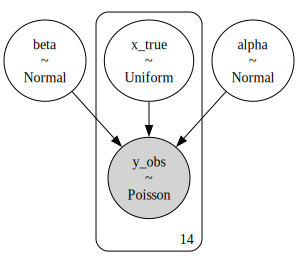

In [18]:
pm.model_to_graphviz(model, save="../images/model.png", include_dim_lengths=True)

In [19]:
def generate_predictions(trace, model, pop_range=None, num_points=100, log_scale=True, quantiles=[0.03, 0.97]):
    posterior = trace.posterior
    
    alpha_samples = posterior['alpha'].values.flatten()
    beta_pop_samples = posterior['beta'].values.flatten()
    
    if pop_range is None:
        pop_range = (1000, 1000000)  # Default range, adjust as needed
        
    if log_scale:
        pop_values = np.logspace(np.log10(pop_range[0]), np.log10(pop_range[1]), num_points)
    else:
        pop_values = np.linspace(pop_range[0], pop_range[1], num_points)
    
    n_samples = len(alpha_samples)
    predictions = np.zeros((n_samples, num_points))
    
    for i in range(n_samples):
        alpha = alpha_samples[i]
        beta_pop = beta_pop_samples[i]
        log_lambda = alpha + beta_pop * np.log(pop_values)
        predictions[i, :] = np.exp(log_lambda)
    
    mean_preds = predictions.mean(axis=0)
    quantile_preds = {}
    for q in quantiles:
        quantile_preds[f"q{int(q*100)}"] = np.quantile(predictions, q, axis=0)
    
    preds_df = pd.DataFrame({
        'pop_estimate': pop_values,
        'estimate': mean_preds
    })
    
    for q, values in quantile_preds.items():
        preds_df[q] = values
    
    preds_df['lower_3.0%'] = preds_df['q3']
    preds_df['upper_97.0%'] = preds_df['q97']
    
    return preds_df

/Users/folgert/projects/coverage-based-standardization/.venv/lib/python3.13/site-packages/rich/live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/folgert/projects/coverage-based-standardization/.venv/lib/python3.13/site-packages/rich/live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[None,
 Text(0.5, 0, 'Population size (log)'),
 Text(0, 0.5, 'Standardized diversity estimate')]

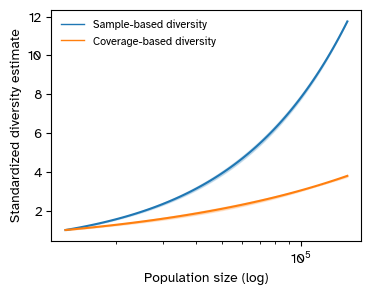

In [20]:
import arviz as az

import logging
logger = logging.getLogger('pymc')
logger.setLevel(logging.WARNING)

fig, ax = plt.subplots(figsize=(4, 3))

for i, variable in enumerate(('raw_richness', 'coverage_rarified_richness')):
    # Create the PyMC model
    model = build_model(df[variable], df['pop_estimate'], df['se'])
    # Fit the model
    with model:
        # Use NUTS sampler (No U-Turn Sampler)
        trace = pm.sample(1000, tune=1000, return_inferencedata=True)

    preds = generate_predictions(
        trace, model, pop_range=(df["pop_estimate"].min(), df["pop_estimate"].max()))
    preds['lci'] = preds['lower_3.0%'] / preds['lower_3.0%'].min()
    preds['uci'] = preds['upper_97.0%'] / preds['upper_97.0%'].min()
    ax.plot(preds['pop_estimate'], preds['estimate'] / preds['estimate'].min(), color=f"C{i}", label=variable)
    ax.fill_between(preds['pop_estimate'], preds['lci'], preds['uci'], alpha=0.2, color=f"C{i}")

custom_lines = [Line2D([0], [0], color=f"C{i}", lw=1) for i in range(2)]
ax.legend(custom_lines, ["Sample-based diversity", "Coverage-based diversity"], 
                        #  bbox_to_anchor=(0.5, 1.05), 
          frameon=False, fontsize=8, columnspacing=0.8)
ax.set(xscale="log", xlabel="Population size (log)", ylabel="Standardized diversity estimate")
# plt.savefig("../images/song-diversity-comparison.png", dpi=300, bbox_inches='tight');

In [21]:
preds

,pop_estimate,estimate,q3,q97,lower_3.0%,upper_97.0%,lci,uci
0,12823.996926,94.614375,87.820221,101.919855,87.820221,101.919855,1.000000,1.000000
1,13146.269043,95.894627,89.125420,103.186667,89.125420,103.186667,1.014862,1.012429
2,13476.639987,97.192254,90.462989,104.458175,90.462989,104.458175,1.030093,1.024905
3,13815.313283,98.507492,91.792604,105.761690,91.792604,105.761690,1.045233,1.037695
4,14162.497573,99.840580,93.117202,107.048171,93.117202,107.048171,1.060316,1.050317
...,...,...,...,...,...,...,...,...
95,135531.090146,340.016187,313.091158,368.299328,313.091158,368.299328,3.565137,3.613617
96,138937.040076,344.634140,317.010216,373.656639,317.010216,373.656639,3.609763,3.666181
97,142428.582876,349.314994,321.005857,379.294071,321.005857,379.294071,3.655261,3.721493
98,146007.869528,354.059609,324.945156,384.877489,324.945156,384.877489,3.700118,3.776276


In [ ]:
def plot_enhanced_regression(df, variable, trace, model, color="C0", ylabel=None, figsize=(5, 3), ax=None):
    # Extract the posterior distribution for x_true
    x_true_posterior = trace.posterior['x_true'].values
    x_true_mean = x_true_posterior.mean(axis=(0, 1))
    x_true_lower = np.percentile(x_true_posterior, 2.5, axis=(0, 1))
    x_true_upper = np.percentile(x_true_posterior, 97.5, axis=(0, 1))
    
    # Generate predictions for the regression line
    preds = generate_predictions(
        trace, model, pop_range=(min(x_true_lower.min(), df["pop_estimate"].min()), 
                                 max(x_true_upper.max(), df["pop_estimate"].max())))
    
    # Create the plot
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    # 1. Plot original population estimates in light grey
    ax.scatter(x_true_mean, df[variable], 
              marker='o', facecolor="none", edgecolor="black", alpha=1,
              zorder=4)
    
    # 2. Plot adjusted population estimates with horizontal error bars
    ax.errorbar(df['pop_estimate'], df[variable], 
               xerr=[df['pop_estimate'] - df['abs_lower'], df['abs_upper'] - df['pop_estimate']],
               fmt='o', ecolor='grey', alpha=0.4, capsize=3,
               markerfacecolor='none', markeredgecolor="none", capthick=0, zorder=3)    
    
    # 3. Plot regression line and CI
    preds['lci'] = preds['lower_3.0%']
    preds['uci'] = preds['upper_97.0%']
    ax.plot(preds['pop_estimate'], preds['estimate'], color, 
           label='Regression Line', zorder=2)
    ax.fill_between(preds['pop_estimate'], preds['lci'], preds['uci'], 
                   alpha=0.2, color=color, label='Regression 95% CI', zorder=1)
    ax.set(xscale="log", ylabel=ylabel)
    return ax


/Users/folgert/projects/coverage-based-standardization/.venv/lib/python3.13/site-packages/rich/live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

                  mean        sd      hdi_3%     hdi_97%  mcse_mean  mcse_sd  \
alpha           -4.386     0.192      -4.754      -4.045      0.004    0.003   
beta             1.003     0.018       0.970       1.036      0.000    0.000   
x_true[0]    13661.017   199.495   13288.342   13868.872      2.754    4.644   
x_true[1]   153030.394  3250.901  147009.183  157127.225     56.967   51.786   
x_true[2]    66622.825   113.018   66419.056   66734.623      1.561    2.901   
x_true[3]    28718.305   117.029   28599.359   28930.179      1.570    3.338   
x_true[4]    59088.549   122.274   58965.258   59301.888      1.669    3.090   
x_true[5]    18800.074   327.848   18453.855   19402.602      4.335    8.830   
x_true[6]    19684.132   500.223   19130.114   20606.100      6.801   10.857   
x_true[7]    16539.886   200.413   16341.636   16903.781      2.625    5.357   
x_true[8]    18583.836   229.906   18156.799   18817.865      2.847    5.025   
x_true[9]    42296.426   521.447   41343

/Users/folgert/projects/coverage-based-standardization/.venv/lib/python3.13/site-packages/rich/live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

                  mean        sd      hdi_3%     hdi_97%  mcse_mean  mcse_sd  \
alpha           -0.574     0.308      -1.158       0.026      0.006    0.005   
beta             0.542     0.029       0.491       0.602      0.001    0.001   
x_true[0]    12643.575   586.879   11779.461   13640.585      7.367    7.504   
x_true[1]   149574.210  4233.201  142979.265  156815.470     59.268   49.361   
x_true[2]    64822.701  1745.991   61545.953   66734.227     24.978   38.367   
x_true[3]    30171.437  1139.753   28606.274   32281.044     16.327   15.427   
x_true[4]    60006.572  1094.991   58965.306   62001.232     15.131   36.583   
x_true[5]    19540.806   914.867   18453.966   21325.562     12.983   15.765   
x_true[6]    21331.791  1077.397   19495.587   22996.911     13.794   14.764   
x_true[7]    17029.496   613.209   16341.931   18213.865      8.407   13.413   
x_true[8]    17698.604   838.590   16114.852   18817.580     12.661   11.993   
x_true[9]    40278.174  1801.525   37119

/Users/folgert/projects/coverage-based-standardization/.venv/lib/python3.13/site-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/folgert/projects/coverage-based-standardization/.venv/lib/python3.13/site-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))


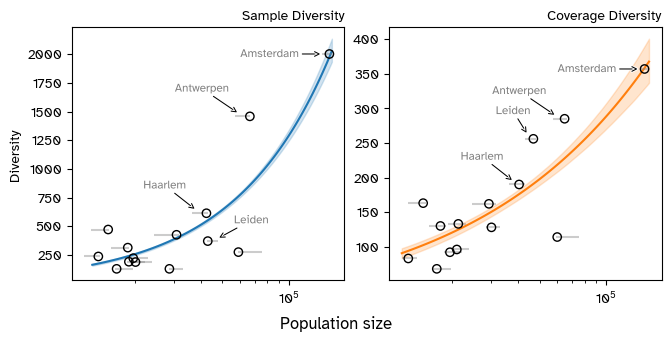

In [23]:
import arviz as az
import matplotlib.patheffects as path_effects
import logging

logger = logging.getLogger('pymc')
logger.setLevel(logging.ERROR)

fig, axes = plt.subplots(figsize=(6.6, 3.3), ncols=2, constrained_layout=True)

model_preds = {}
for i, variable in enumerate(('raw_richness', 'coverage_rarified_richness')):
    model = build_model(df[variable], df['pop_estimate'], df['se'])
    # Fit the model
    with model:
        # Use NUTS sampler (No U-Turn Sampler)
        trace = pm.sample(1000, tune=1000, return_inferencedata=True)
    print(az.summary(trace))
    preds = generate_predictions(
        trace, model, pop_range=(df["pop_estimate"].min(), df["pop_estimate"].max()))
    model_preds[variable] = preds, model, trace

#     preds['lci'] = preds['lower_3.0%'] / preds['lower_3.0%'].min()
#     preds['uci'] = preds['upper_97.0%'] / preds['upper_97.0%'].min()
#     axes[2].plot(preds['pop_estimate'], preds['estimate'] / preds['estimate'].min(), color=f"C{i}", label=variable)
#     axes[2].fill_between(preds['pop_estimate'], preds['lci'], preds['uci'], alpha=0.2, color=f"C{i}")

# custom_lines = [Line2D([0], [0], color=f"C{i}", lw=1) for i in range(2)]
# axes[2].legend(custom_lines, ["Sample-based diversity", "Coverage-based diversity"], 
#                         #  bbox_to_anchor=(0.5, 1.05), 
#           frameon=False, fontsize=8, columnspacing=0.8)
# axes[2].set(xscale="log")
# axes[2].set_title("Standardized diversity", fontsize=10, loc="right")


to_annotate = 'Amsterdam', 'Leiden', 'Haarlem', 'Antwerpen'

preds, model, trace = model_preds['raw_richness']
plot_enhanced_regression(df, 'raw_richness', trace, model, ax=axes[0])
axes[0].set_xlabel("")

for place in to_annotate:
    row = df[df['collection'] == place]
    if place == "Amsterdam":
        x, y = (-20, 0)
    elif place == "Haarlem":
        x, y = (-10, 20)
    elif place == "Leiden":
        x, y = (40, 15)
    text = axes[0].annotate(
            place, 
            (row['pop_estimate'], row['raw_richness']), 
            xycoords="data",
            xytext=(x, y),
            textcoords="offset points",
            ha="right",
            va="center",
            color="grey",
            size="small",
            arrowprops=dict(
                arrowstyle="->", shrinkA=0, shrinkB=5, color="black", linewidth=0.75))

    text.set_path_effects(
        [path_effects.Stroke(linewidth=2, foreground="white"), path_effects.Normal()])
    text.arrow_patch.set_path_effects(
        [path_effects.Stroke(linewidth=2, foreground="white"), path_effects.Normal()])

axes[0].set(xscale="log", ylabel="Diversity")
axes[0].set_title("Sample Diversity", fontsize=10, loc="right")

preds, model, trace = model_preds['coverage_rarified_richness']
plot_enhanced_regression(df, 'coverage_rarified_richness', trace, model, ax=axes[1], color="C1")

for place in to_annotate:
    row = df[df['collection'] == place]
    if place == "Amsterdam":
        x, y = (-20, 0)
    elif place == "Haarlem":
        x, y = (-10, 20)
    elif place == "Leiden":
        x, y = (0, 20)
    text = axes[1].annotate(
            place, 
            (row['pop_estimate'], row['coverage_rarified_richness']), 
            xycoords="data",
            xytext=(x, y),
            textcoords="offset points",
            ha="right",
            va="center",
            color="grey",
            size="small",
            arrowprops=dict(
                arrowstyle="->", shrinkA=0, shrinkB=5, color="black", linewidth=0.75))

    text.set_path_effects(
        [path_effects.Stroke(linewidth=2, foreground="white"), path_effects.Normal()])
    text.arrow_patch.set_path_effects(
        [path_effects.Stroke(linewidth=2, foreground="white"), path_effects.Normal()])

axes[1].set(xscale="log")
axes[1].set_title("Coverage Diversity", fontsize=10, loc="right")
fig.supxlabel("Population size")
plt.savefig("../images/regression-song-panel-pop-error.png", dpi=300, bbox_inches='tight');